In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

c:\Users\kainak0\Documents\gitProjects\mia\MIA-203_redes_neuronales\parcial\facial_expression_recognition\ferpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\kainak0\.cache\kagglehub\datasets\ananthu017\emotion-detection-fer\versions\1


In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("noamsegal/affectnet-training-data")

# print("Path to dataset files:", path)

In [3]:
!ls -la {path}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import random_split,Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [5]:
train = os.path.join(path, 'train')
test = os.path.join(path, 'test')
classes_train = os.listdir(train)
classes_train_size = []
classes_test = os.listdir(test)
classes_test_size = []

for i in range(len(classes_train)):
    size = len(os.listdir(train+'/'+classes_train[i]))
    print(f"# of images in class train {classes_train[i]}: {size}")
    classes_train_size.append(size)
    print(f"total : {sum(classes_train_size)}")
for i in range(len(classes_test)):
    size = len(os.listdir(train+'/'+classes_test[i]))
    print(f"# of images in class test {classes_test[i]}: {size}")
    classes_train_size.append(size)
    print(f"total : {sum(classes_test_size)}")



# of images in class train angry: 3995
total : 3995
# of images in class train disgusted: 436
total : 4431
# of images in class train fearful: 4097
total : 8528
# of images in class train happy: 7215
total : 15743
# of images in class train neutral: 4965
total : 20708
# of images in class train sad: 4830
total : 25538
# of images in class train surprised: 3171
total : 28709
# of images in class test angry: 3995
total : 0
# of images in class test disgusted: 436
total : 0
# of images in class test fearful: 4097
total : 0
# of images in class test happy: 7215
total : 0
# of images in class test neutral: 4965
total : 0
# of images in class test sad: 4830
total : 0
# of images in class test surprised: 3171
total : 0


In [6]:
img = Image.open(os.path.join(train,'angry/im1.png'))

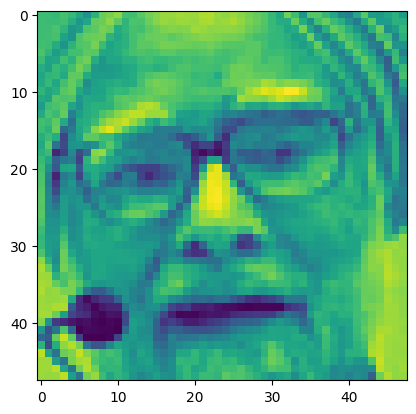

In [7]:
plt.imshow(img)

# VGG16

In [8]:
# Define the VGG16-like model
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        
        # Define the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pool 1
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Conv4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pool 2

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Conv5
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Conv6
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Conv7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pool 3
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Conv8
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv9
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pool 4
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv11
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv12
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pool 5
        )
        
        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Adjust input size for 224x224 input images
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  # Output layer
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output from conv layers
        x = self.fc_layers(x)
        return x

In [9]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0])
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

In [10]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [11]:
# Create the ResNet model
def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2], num_classes=7)  # ResNet-18

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)

In [12]:
### Acondicionamiento del dataset
# Definir transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiar el tamaño de las imágenes
    transforms.ToTensor(),          # Convertir las imágenes en tensores
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización
])

# Cargar el dataset

dataset_train = datasets.ImageFolder(os.path.join(train), transform=transform)
dataset_test = datasets.ImageFolder(os.path.join(test), transform=transform)

train_size, val_size = int(len(dataset_train)), int(len(dataset_test))


train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True) # shuffle to avoid memorization (overfitting)
val_loader = DataLoader(dataset_test, batch_size=64, shuffle=False)

In [ ]:
# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/30], Loss: 1.7840
Epoch [2/30], Loss: 1.7683
Epoch [3/30], Loss: 1.7622
Epoch [4/30], Loss: 1.7385
Epoch [5/30], Loss: 1.6752
Epoch [6/30], Loss: 1.5590
Epoch [7/30], Loss: 1.4719
Epoch [8/30], Loss: 1.4066
Epoch [9/30], Loss: 1.3574
Epoch [10/30], Loss: 1.3119
Epoch [11/30], Loss: 1.2742
Epoch [12/30], Loss: 1.2329
Epoch [13/30], Loss: 1.1984
Epoch [14/30], Loss: 1.1696
Epoch [15/30], Loss: 1.1301
Epoch [16/30], Loss: 1.0989
Epoch [17/30], Loss: 1.0648
Epoch [18/30], Loss: 1.0370
Epoch [19/30], Loss: 1.0084
Epoch [20/30], Loss: 0.9701
Epoch [21/30], Loss: 0.9453
Epoch [22/30], Loss: 0.9069
Epoch [23/30], Loss: 0.8704
Epoch [24/30], Loss: 0.8360
Epoch [25/30], Loss: 0.7967


### Testing

In [14]:
### Testing
# Testing the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%')

Accuracy of the model on the 10,000 test images: 48.97%


In [15]:
torch.save(model.state_dict(), 'models/ResNET_FER.pth')

C:\Users\kainak0\AppData\Local\Temp\ipykernel_28508\2189748307.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


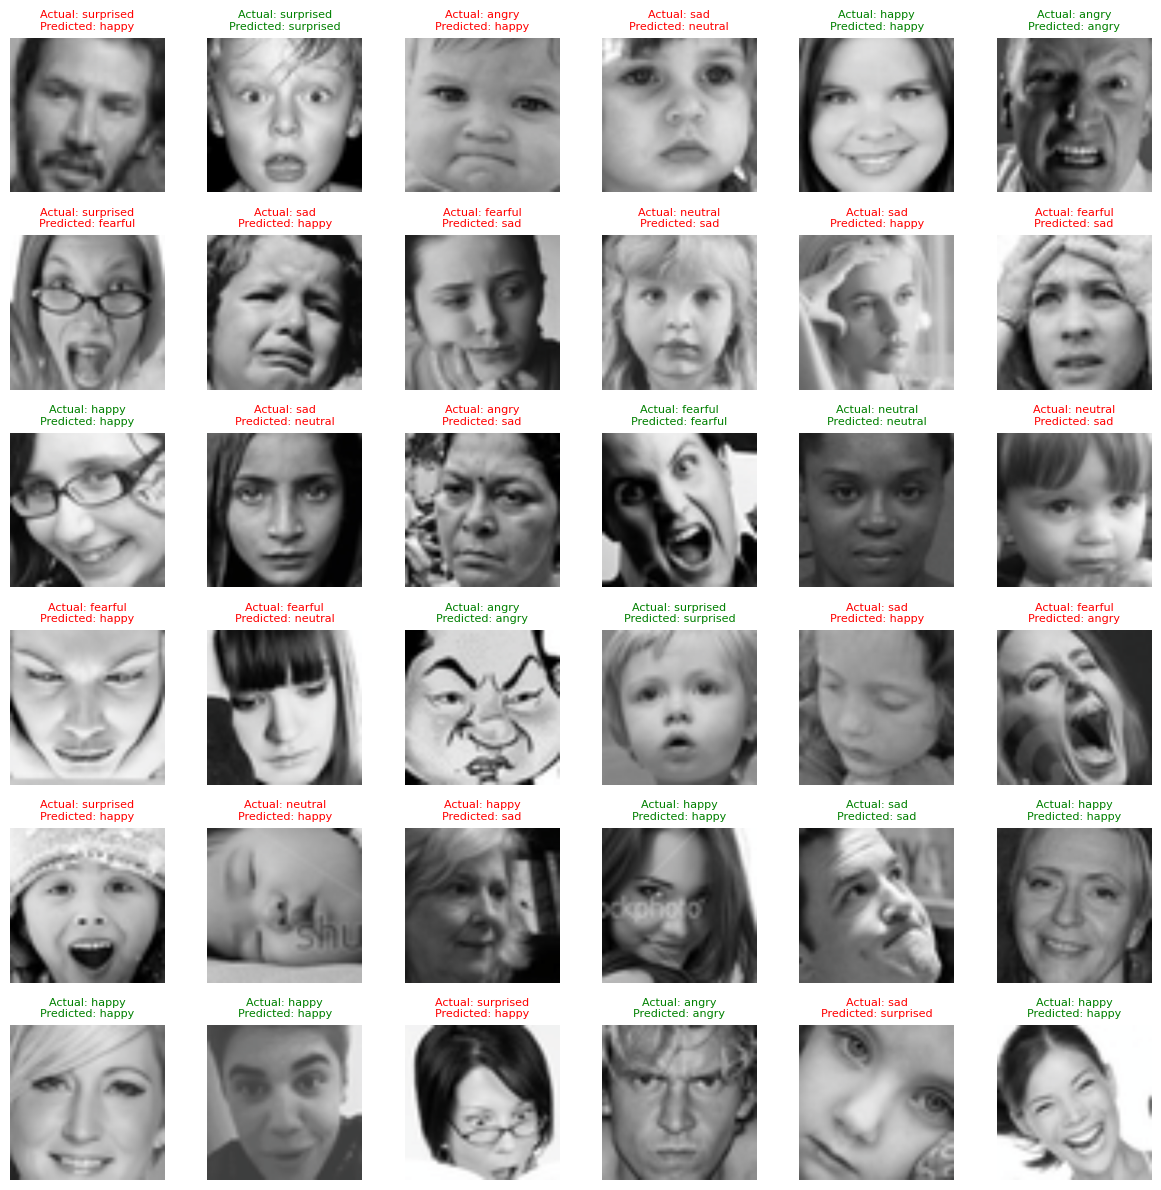

In [17]:
import matplotlib.pyplot as plt
import random
import torchvision

def show_random_test_predictions(model, dataloader, class_names, num_images=16):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(6, 6, figsize=(12, 12))
    axes = axes.flatten()

    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_images.extend(inputs.cpu())
            all_labels.extend(labels.cpu())
            all_preds.extend(preds.cpu())

    combined = list(zip(all_images, all_labels, all_preds))
    random.shuffle(combined)

    selected_images = random.sample(combined, min(num_images, len(combined)))

    for idx, (img, label, pred) in enumerate(selected_images):
        ax = axes[images_shown]
        ax.axis('off')

        img = img.numpy().transpose((1, 2, 0))
        img = np.clip((img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

        ax.imshow(img)

        predicted_class = class_names[pred]
        actual_class = class_names[label]
        title = f'Actual: {class_names[label]}\nPredicted: {class_names[pred]}'

        if predicted_class == actual_class:
            ax.set_title(title, color='green',fontsize=8)
        else:
            ax.set_title(title, color='red',fontsize=8)

        images_shown += 1
        if images_shown == num_images:
            break

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = 'models/ResNET_FER.pth'
model = ResNet18().to(device)
model.load_state_dict(torch.load(path))
show_random_test_predictions(model, val_loader, classes_train, num_images=36)

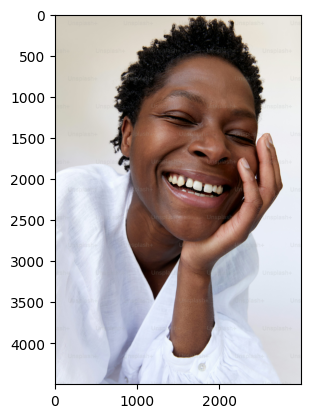

In [16]:
img = Image.open('prueba.jpeg')
plt.imshow(img)

### Validation

In [18]:

# Training Results
print('hi')


hi
